In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [2]:
#use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406])
normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [4]:
imsize =  100

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  
    transforms.ToTensor()]) 

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return torch.tensor(image).float()

def image_loader2(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return torch.tensor(image).float()

style_img = image_loader("rain.jpg")
content_img = image_loader("content.jpg")

In [5]:
unloader = transforms.ToPILImage()  

def imshow(tensor, title=None): 
    if len(tensor.size()) == 4:
        tensor = tensor.squeeze(0)
    image = unloader(tensor)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

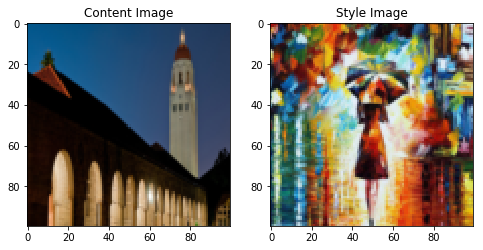

In [6]:
plt.figure(figsize=(8,8))

plt.subplot(121)
imshow(content_img, title='Content Image')

plt.subplot(122)
imshow(style_img, title='Style Image')

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input_feature):
        self.loss = F.mse_loss(input_feature, self.target)
        return input_feature

In [8]:
def kernel(v1, v2):
    K = torch.pow(torch.mm(v1.t(), v2),2)
    return K

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        a, b, c, d = target_feature.size() 
        self.target = target_feature.view(a * b, c * d).detach()

    def forward(self, input_feature):
        a, b, c, d = input_feature.size()
        input_f = input_feature.view(a * b, c * d)
        k1, k2, k12 = kernel(input_f,input_f), kernel(self.target,self.target), kernel(input_f,self.target)
        expr = k1+k2-2*k12
        self.loss = torch.sum(expr).div(a^2*b^2*c^2*d^2)
        return input_feature

In [10]:
net = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
content_layers_default = ['conv_3']
style_layers_default = ['conv_1', 'conv_2', 'conv_3','conv_5']

def get_model_style_content_losses(net, style_img, content_img, content_layers=content_layers_default,
                               style_layers=style_layers_default):
    net = copy.deepcopy(net)
    normalization = Normalization(normalization_mean, normalization_std)
    model = nn.Sequential(normalization)
    
    content_losses = []
    style_losses = []

    i, j  = 0, 0 
    for layer in net.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        
        if name in content_layers:
            j += 1
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            j += 1
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
            
        if j == len(content_layers_default) + len(style_layers_default):
            break

    return model, style_losses, content_losses

In [12]:
def get_input_optimizer(input_img):
    optimizer = optim.Adam([input_img.requires_grad_()])
    return optimizer

In [13]:
def run_style_transfer(net, content_img, style_img, input_img, n_epochs=10,
                       style_weight=1, content_weight= 1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_model_style_content_losses(net, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    
    for epoch in range(n_epochs):

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score 
            loss.backward()
            
            if epoch % 50 == 0:
                print("Epoch {}:".format(epoch))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))

            return style_score + content_score 

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)

    return input_img

In [14]:
input_img = image_loader("content.jpg")

In [15]:
output = run_style_transfer(net,content_img, style_img, input_img, style_weight=10e-9, content_weight=1, n_epochs=300)

Building the style transfer model..
Optimizing..
Epoch 0:
Style Loss : 3307.984619 Content Loss: 0.000000
Epoch 50:
Style Loss : 884.457947 Content Loss: 5.315056
Epoch 100:
Style Loss : 472.825165 Content Loss: 9.818883
Epoch 150:
Style Loss : 326.988312 Content Loss: 12.520942
Epoch 200:
Style Loss : 240.884140 Content Loss: 14.442367
Epoch 250:
Style Loss : 185.084473 Content Loss: 15.989791


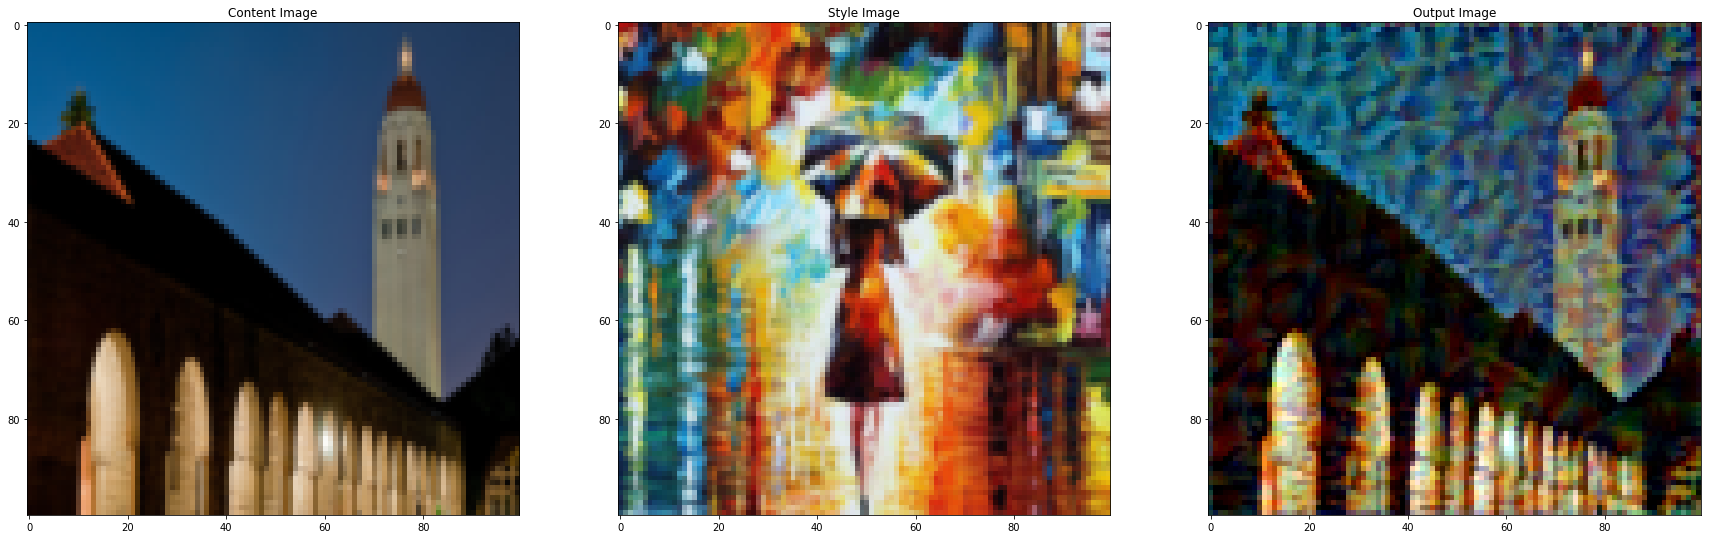

In [16]:
plt.figure(figsize=(30,30))
plt.subplot(131)
imshow(content_img, title='Content Image')

plt.subplot(132)
imshow(style_img, title='Style Image')

plt.subplot(133)
imshow(output, title='Output Image');


In [17]:
def kernel(v1, v2):
    v1 = v1 - torch.mean(v1)
    v2 = v2 - torch.mean(v2)
    s = torch.sum(torch.mm(v1.t(), v2))
    K = torch.exp(-torch.pow(v1-v2,2)/s)
    return K

In [18]:
input_img = image_loader("content.jpg")

In [19]:
output = run_style_transfer(net,content_img, style_img, input_img, style_weight=10e6, content_weight= 1, n_epochs=300)

Building the style transfer model..
Optimizing..
Epoch 0:
Style Loss : 2110.285156 Content Loss: 0.000000
Epoch 50:
Style Loss : 773.662903 Content Loss: 5.037238
Epoch 100:
Style Loss : 477.304138 Content Loss: 9.773293
Epoch 150:
Style Loss : 311.299927 Content Loss: 13.967519
Epoch 200:
Style Loss : 211.257401 Content Loss: 17.600832
Epoch 250:
Style Loss : 145.019089 Content Loss: 20.825819


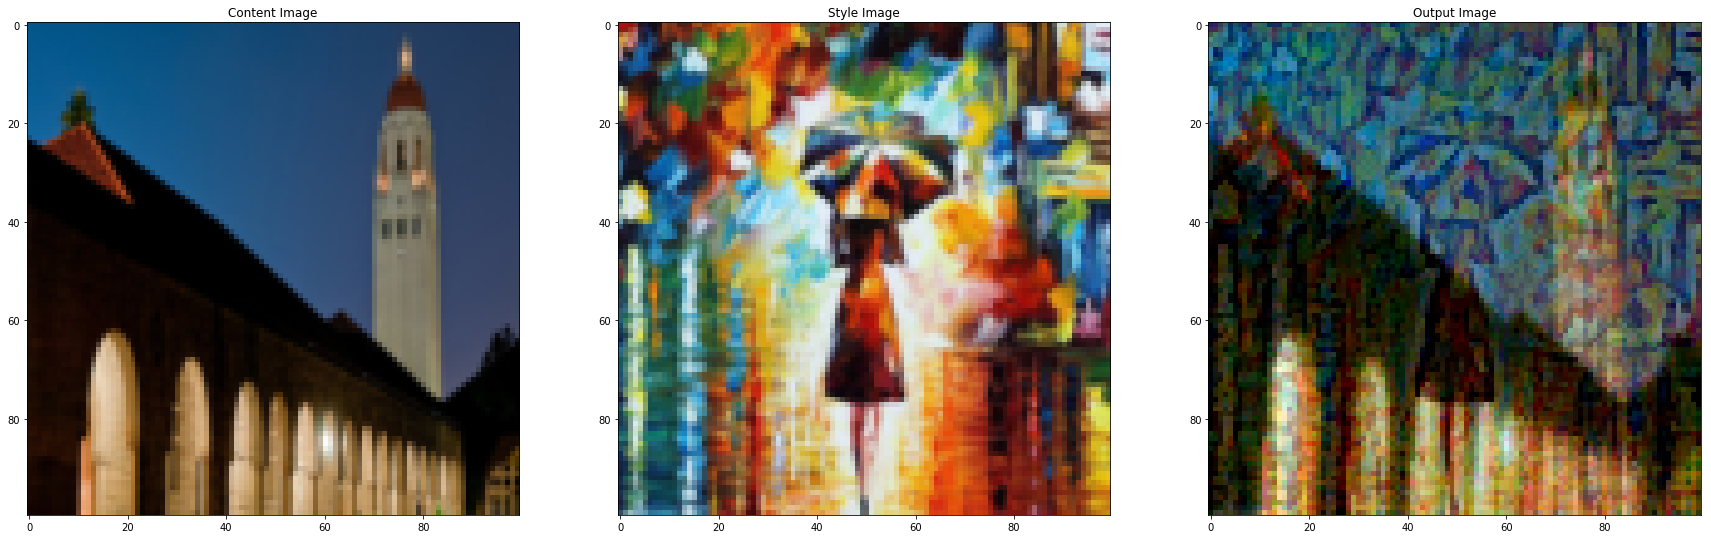

In [20]:
plt.figure(figsize=(30,30))
plt.subplot(131)
imshow(content_img, title='Content Image')

plt.subplot(132)
imshow(style_img, title='Style Image')

plt.subplot(133)
imshow(output, title='Output Image');
